In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load the File

In [2]:
train = pd.read_csv('fraudTrain.csv')
test = pd.read_csv('fraudTest1.csv')
slice = pd.read_csv('slice2000.csv')

In [3]:
#Creating the data frame and start the dataset from column 1
df_train = train.iloc[0:,1:]
df_test = test.iloc[20000:,1:]
df_slice = slice.iloc[0:,1:]
df_train1 = df_train.copy()
df_test1 = df_test.copy()
df_train.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [4]:
#Functions that will be used to transform the data

def is_weekend(tx_datetime):
    
    # Convert date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6am and more than 10pm, and 0 otherwise
    is_night = (tx_hour<=6 and tx_hour>=22)
    
    return int(is_night)

def show_status(df):
    
    #Get the status about null values, cell type
    total_null = df.isnull().sum()
    percent_null = 100* (total_null/len(df))
    cell_type = df.dtypes
    unique_values = df.nunique()

    new_table = pd.concat([total_null,percent_null,cell_type,unique_values], axis=1)
    tb_columns = new_table.rename(columns = {0: 'Null Values', 1: '% of Null Values', 2: 'Type', 3:'Unique Values'})
    
    return tb_columns

#TODO we need to find a better way to calculate the age, this function is too slow.
#def calculate_age(born):
#    now = pd.Timestamp('now').year
#    born = pd.to_datetime(born)    # 1
#    return (now - born)    # 3


#function to return highly correlated column above a threshold
def correlation(dataset, threshold):
    col_corr = set() # This set stores the highly correlated columns
    corr_matrix = dataset.corr() #correlation matrix
    #traversing the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i,j] > threshold:
                colname = corr_matrix.columns[i] #selecting columns above threshold
                col_corr.add(colname) #adding columns to set
    return col_corr


In [5]:
show_status(df_train)

,Null Values,% of Null Values,Type,Unique Values
trans_date_trans_time,0,0.0,object,1274791
cc_num,0,0.0,int64,983
merchant,0,0.0,object,693
category,0,0.0,object,14
amt,0,0.0,float64,52928
first,0,0.0,object,352
last,0,0.0,object,481
gender,0,0.0,object,2
street,0,0.0,object,983
city,0,0.0,object,894


In [6]:
#df_train = df_train.drop('Unnamed: 0', axis=1)
#train dataset
df_train.rename(columns={'trans_date_trans_time':'TX_DATETIME','cc_num':'ACCOUNT','amt':'AMOUNT', 'category':'CATEGORY'}, inplace=True)
#test dataset
df_test.rename(columns={'trans_date_trans_time':'TX_DATETIME','cc_num':'ACCOUNT','amt':'AMOUNT', 'category':'CATEGORY'}, inplace=True)

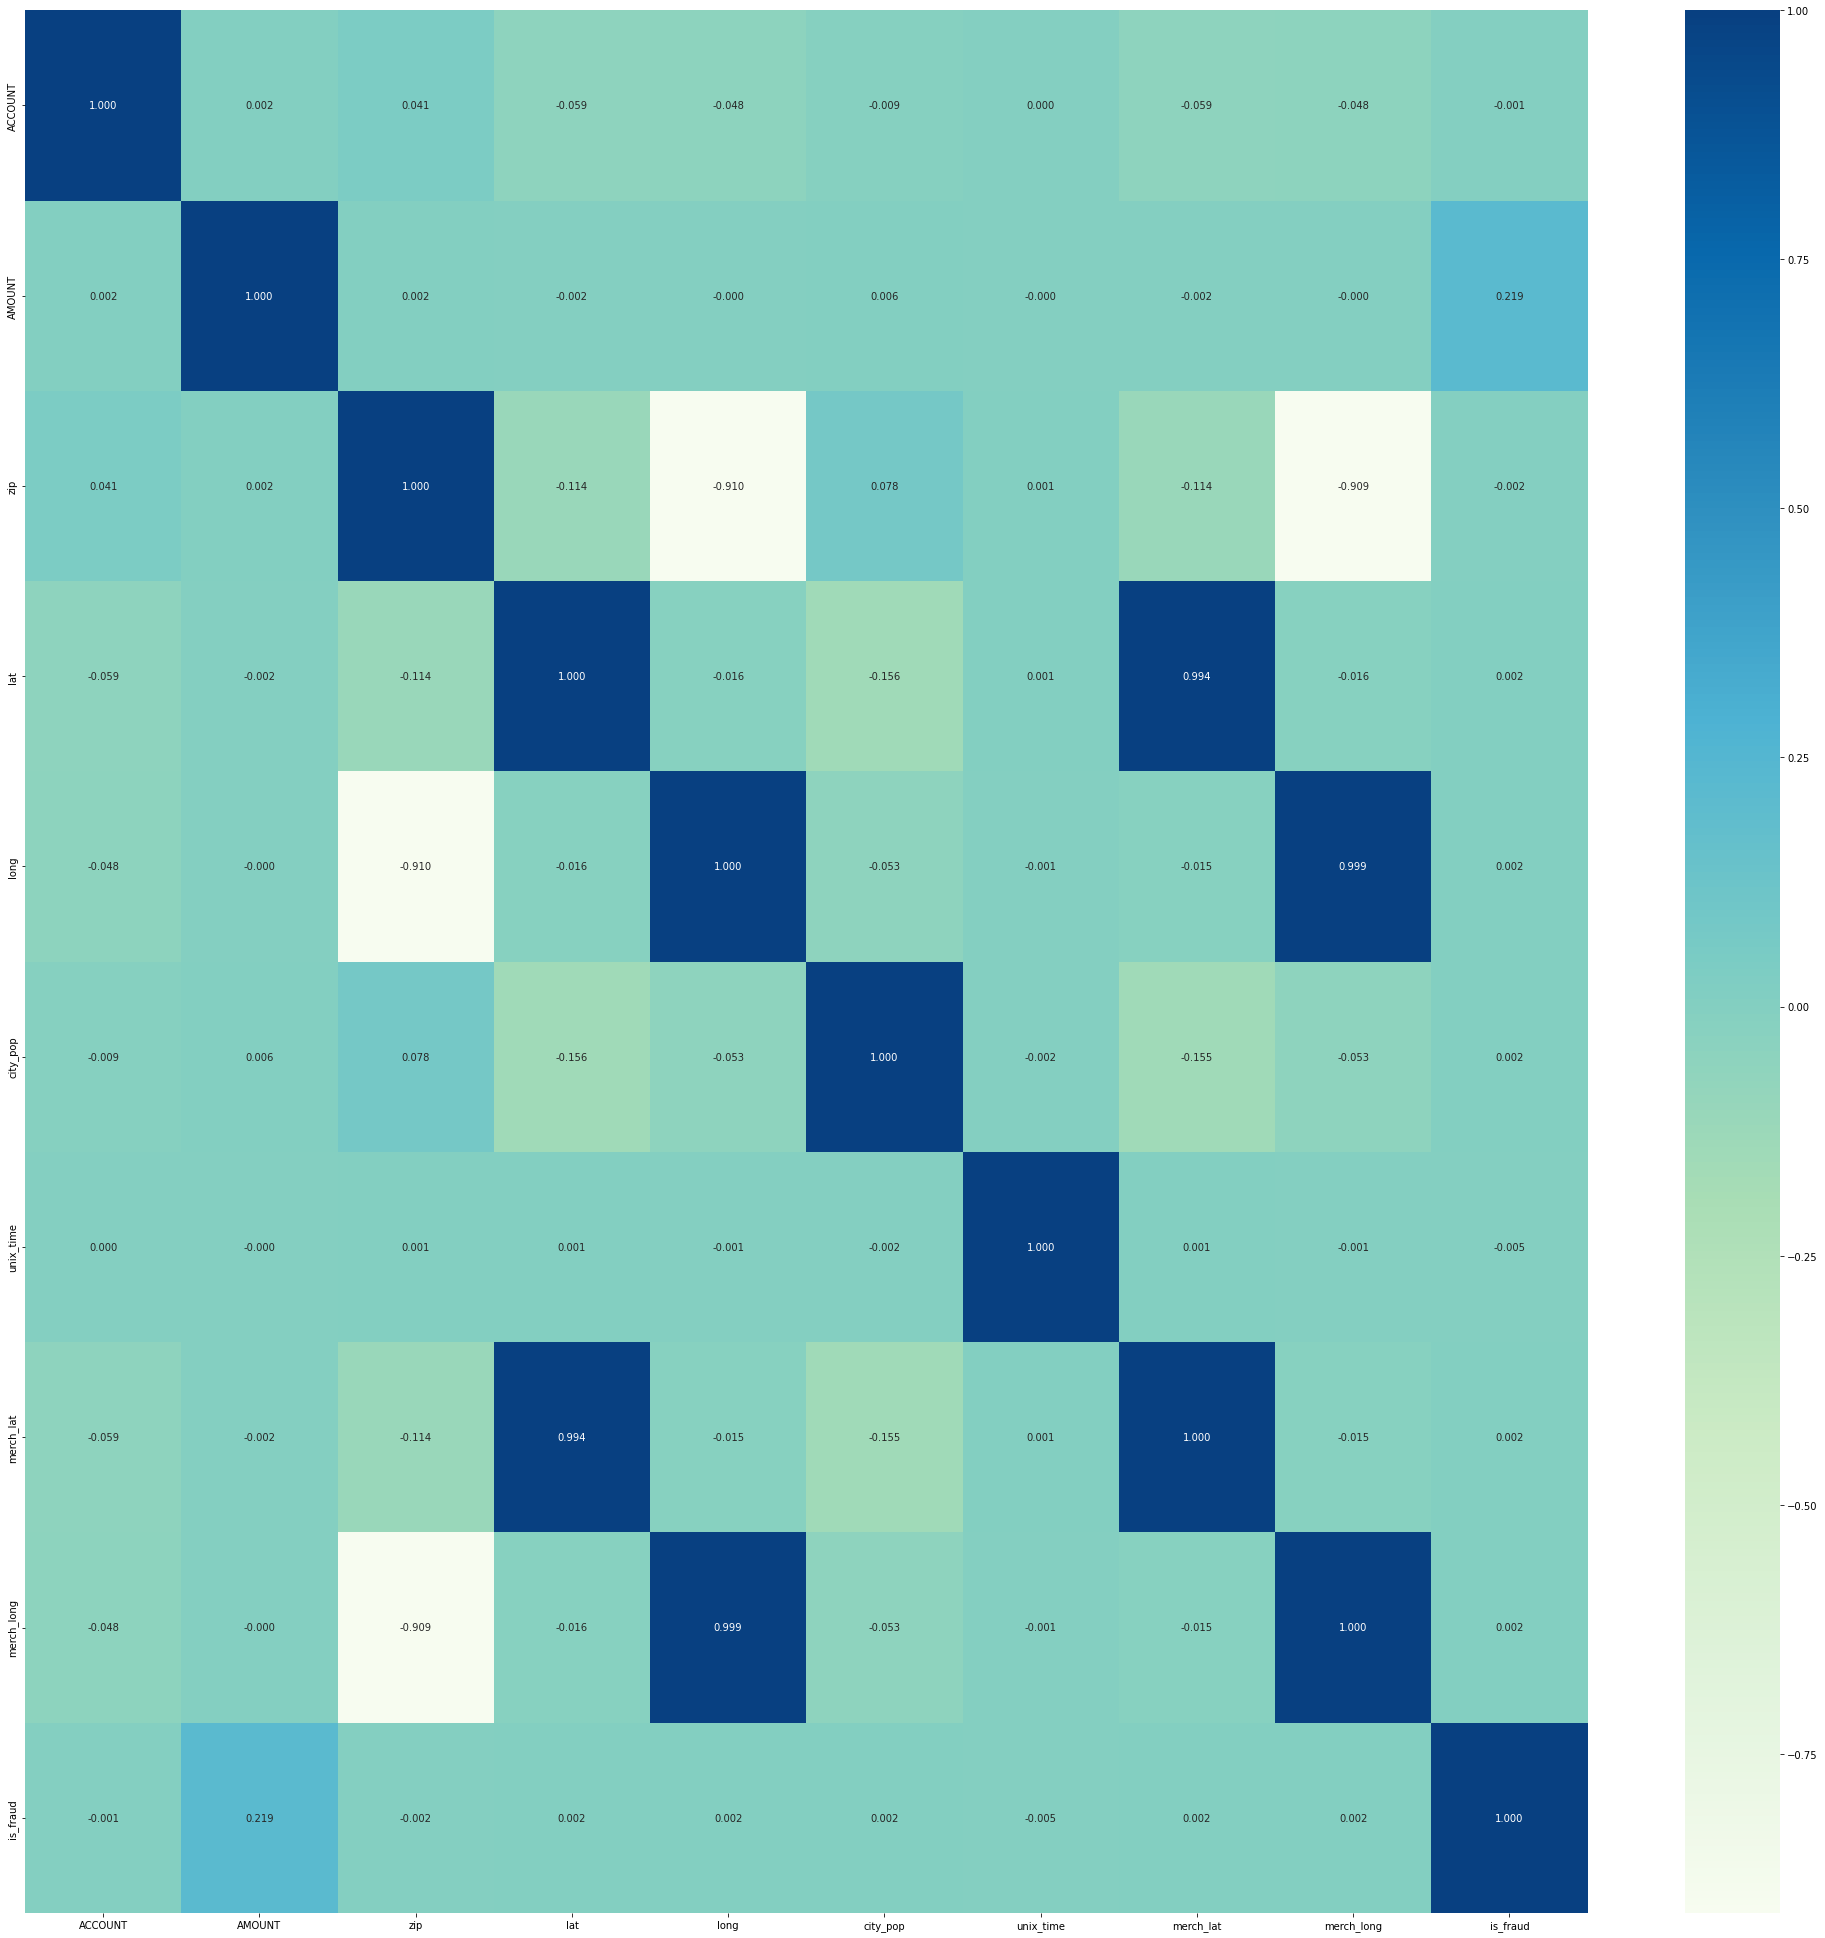

In [7]:
#df_train.corr()
plt.figure(figsize = (35,35))
sns.heatmap(df_train.corr(),annot = True, cmap="GnBu",fmt='.3f')
plt.show()

#plt.figure(figsize = (35,35))
#sns.heatmap(df_test.corr(),annot = True, cmap="GnBu",fmt='.2f')
#plt.show()

In [8]:
#let us get the features with correlation above 85%
corr_features = correlation(df_train,0.85)
corr_features

{'merch_lat', 'merch_long'}

In [9]:
corr_test = correlation(df_test,0.85)
corr_test

{'merch_lat', 'merch_long'}

In [10]:
#we need to delete merch_lat and merch_long

In [11]:
#Number of lines and columns
#Train dataset
df_train[df_train.is_fraud == 1].shape, df_train[df_train.is_fraud == 0].shape

((7506, 22), (1289169, 22))

In [12]:
#TRAINING
num_true_cases = len(df_train[df_train.is_fraud == 1])
num_false_cases = len(df_train[df_train.is_fraud == 0])
print('TRAINING - Number of Fraud cases:',num_true_cases,'-', np.round(num_true_cases / df_train.shape[0] * 100,2),'%')
print('TRAINING - Number of Normal cases:', num_false_cases,'-',np.round(num_false_cases / df_train.shape[0] * 100,2),'%')

#TESTING
num_true_cases = len(df_test[df_test.is_fraud == 1])
num_false_cases = len(df_test[df_test.is_fraud == 0])
print('TESTING - Number of Fraud cases:',num_true_cases,'-', np.round(num_true_cases / df_test.shape[0] * 100,2),'%')
print('TESTING - Number of Normal cases:', num_false_cases,'-',np.round(num_false_cases / df_test.shape[0] * 100,2),'%')

TRAINING - Number of Fraud cases: 7506 - 0.58 %
TRAINING - Number of Normal cases: 1289169 - 99.42 %
TESTING - Number of Fraud cases: 1977 - 0.38 %
TESTING - Number of Normal cases: 513742 - 99.62 %


In [13]:
df_test[df_test.is_fraud == 1]

,TX_DATETIME,ACCOUNT,merchant,CATEGORY,AMOUNT,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
20837,2020-07-05 17:04:01,4989847570577635369,"fraud_McDermott, Osinski and Morar",home,252.48,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,...,34.1832,-81.5324,8333,Archaeologist,1994-07-09,9b3c14d97332ea51409c55a4051d43a9,1373043841,34.278473,-80.690750,1
21719,2020-07-05 22:13:31,4989847570577635369,fraud_Kozey-Kuhlman,personal_care,21.11,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,...,34.1832,-81.5324,8333,Archaeologist,1994-07-09,db58a9737e9c64eabcf5b5671e5e45e3,1373062411,34.658999,-81.376431,1
21762,2020-07-05 22:29:31,4462038234743679432,fraud_Roberts-Beahan,misc_pos,51.79,Kimberly,Bush,F,6027 Scott Meadows Suite 494,Dell City,...,31.9240,-105.2099,579,Hydrogeologist,1945-11-26,15c478b387213744e5f32e43aae247c2,1373063371,32.128386,-105.636375,1
21808,2020-07-05 22:49:40,4989847570577635369,fraud_Cartwright PLC,kids_pets,19.44,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,...,34.1832,-81.5324,8333,Archaeologist,1994-07-09,418f9df03ce9c83407f01a23d725c421,1373064580,34.216526,-81.815763,1
21887,2020-07-05 23:14:28,4989847570577635369,"fraud_Streich, Rolfson and Wilderman",kids_pets,17.05,Vanessa,Anderson,F,21178 Brittney Locks,Prosperity,...,34.1832,-81.5324,8333,Archaeologist,1994-07-09,7aa13ea1866b4a78e76bc68ce8ca95be,1373066068,33.595052,-82.012200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497197,2020-12-22 22:05:48,2242176657877538,"fraud_Willms, Kris and Bergnaum",shopping_pos,1041.51,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,35b0297dd026d2e9a75d024a5dec7955,1387749948,34.573471,-89.911011,1
497274,2020-12-22 22:18:07,2242176657877538,fraud_Kuhn LLC,shopping_pos,868.09,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,da7f67d7375f10a054a3d919448c45dd,1387750687,34.091227,-90.390612,1
497341,2020-12-22 22:31:48,2242176657877538,"fraud_Mosciski, Ziemann and Farrell",shopping_net,1039.42,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,25b076c7bcd70f272c1c5326bb234f4b,1387751508,34.628434,-90.284780,1
497529,2020-12-22 23:06:03,2242176657877538,fraud_Bauch-Raynor,grocery_pos,289.27,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,2df7d894868fbc99ec1d8b055585fc9d,1387753563,34.746063,-90.401093,1


In [14]:
#Data Tranformation

df_train['TX_DATETIME'] = pd.to_datetime(df_train['TX_DATETIME'], errors='coerce')
df_train['dob'] = pd.to_datetime(df_train['dob'], errors='coerce')
df_train['Transaction_Date'] = (df_train['TX_DATETIME']).dt.date.astype('datetime64[ns]')
#Manually calculate the age - seems to be faster
df_train['Age'] = pd.Timestamp('now').year - df_train['dob'].dt.year

df_test['TX_DATETIME'] = pd.to_datetime(df_test['TX_DATETIME'], errors='coerce')
df_test['dob'] = pd.to_datetime(df_test['dob'], errors='coerce')
df_test['Transaction_Date'] = (df_test['TX_DATETIME']).dt.date.astype('datetime64[ns]')
#Manually calculate the age - seems to be faster
df_test['Age'] = pd.Timestamp('now').year - df_test['dob'].dt.year


In [15]:
#Data Tranformation

#It takes 4 sec because it does comparation with the functions
%time df_train['TX_DURING_WEEKEND']=df_train.TX_DATETIME.apply(is_weekend)
%time df_train['TX_DURING_NIGHT']=df_train.TX_DATETIME.apply(is_night)
#it takes 90ms because it only converts the values using dt properties
%time df_train['DAY'] = df_train['TX_DATETIME'].dt.day
%time df_train['MONTH'] = df_train['TX_DATETIME'].dt.month
%time df_train['YEAR'] = df_train['TX_DATETIME'].dt.year


df_test['TX_DURING_WEEKEND']=df_test.TX_DATETIME.apply(is_weekend)
df_test['TX_DURING_NIGHT']=df_test.TX_DATETIME.apply(is_night)
df_test['DAY'] = df_test['TX_DATETIME'].dt.day
df_test['MONTH'] = df_test['TX_DATETIME'].dt.month
df_test['YEAR'] = df_test['TX_DATETIME'].dt.year

Wall time: 5.01 s
Wall time: 4.67 s
Wall time: 95 ms
Wall time: 94 ms
Wall time: 98 ms


In [16]:
#Data Tranformation

#If I want to check the elapse of days since the first day from the dataset
df_train_min = min(df_train['TX_DATETIME'])
df_test_min = min(df_test['TX_DATETIME'])

df_train['TX_TIME_DAYS'] = [int(i.days) for i in (df_train['TX_DATETIME']) - df_train_min]
df_test['TX_TIME_DAYS'] = [int(i.days) for i in (df_test['TX_DATETIME']) - df_test_min]

df_train.head(2)

,TX_DATETIME,ACCOUNT,merchant,CATEGORY,AMOUNT,first,last,gender,street,city,...,merch_long,is_fraud,Transaction_Date,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,YEAR,TX_TIME_DAYS
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,0,2019-01-01,34,0,0,1,1,2019,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,0,2019-01-01,44,0,0,1,1,2019,0


In [17]:
df_test.head(1)


,TX_DATETIME,ACCOUNT,merchant,CATEGORY,AMOUNT,first,last,gender,street,city,...,merch_long,is_fraud,Transaction_Date,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,YEAR,TX_TIME_DAYS
20000,2020-07-05 12:13:02,6011693194885790,fraud_Lesch Ltd,shopping_pos,7.03,Victoria,Fleming,F,2807 Parker Station Suite 080,Stanchfield,...,-93.458067,0,2020-07-05,27,1,0,5,7,2020,0


In [18]:
## check the class imbalance
fraud_train = df_train.is_fraud.value_counts()
print (fraud_train)
print ("Minority class represents just ",(fraud_train[1]/len(df_train))*100, " % of the dataset")

0    1289169
1       7506
Name: is_fraud, dtype: int64
Minority class represents just  0.5788651743883394  % of the dataset


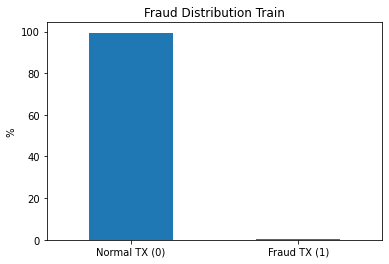

In [19]:
#Class Imbalance - Train
count_classes = pd.value_counts(df_train['is_fraud'], sort = True)/len(df_train)*100
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Fraud Distribution Train")
LABELS = ["Normal TX (0)", "Fraud TX (1)"]
plt.xticks(range(2), LABELS)
plt.ylabel(" % ")
plt.show()

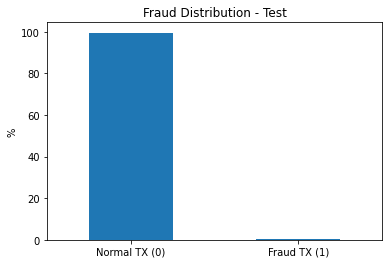

In [20]:
#Class Imbalance - Test
count_classes = pd.value_counts(df_test['is_fraud'], sort = True)/len(df_test)* 100
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Fraud Distribution - Test")
LABELS = ["Normal TX (0)", "Fraud TX (1)"]
plt.xticks(range(2), LABELS)
plt.ylabel("%")
plt.show()

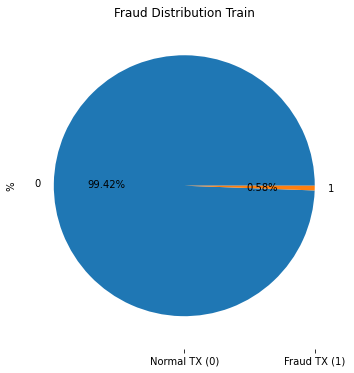

In [21]:
#Class Imbalance - Train
count_classes = pd.value_counts(df_train['is_fraud'], sort = True)/len(df_train)*100
count_classes.plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%')
plt.title("Fraud Distribution Train")
LABELS = ["Normal TX (0)", "Fraud TX (1)"]
plt.xticks(range(2), LABELS)
plt.ylabel(" % ")
plt.show()

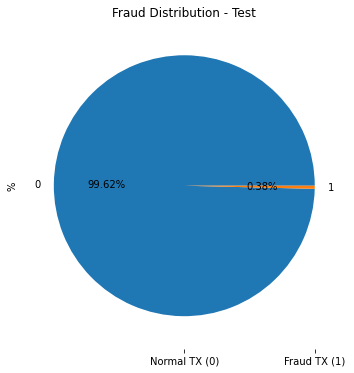

In [22]:
#Class Imbalance - Test
count_classes = pd.value_counts(df_test['is_fraud'], sort = True)/len(df_test)* 100
count_classes.plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%')
plt.title("Fraud Distribution - Test")
LABELS = ["Normal TX (0)", "Fraud TX (1)"]
plt.xticks(range(2), LABELS)
plt.ylabel("%")
plt.show()

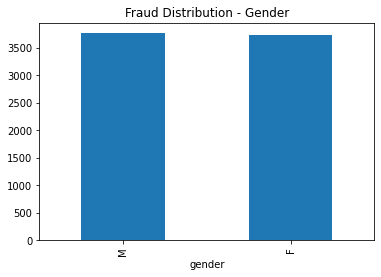

In [23]:
#Class Imbalance - Test
count_classes = df_train.groupby('gender')['is_fraud'].sum().sort_values(ascending=False)
count_classes.plot(kind='bar', figsize=(6,4))
plt.title("Fraud Distribution - Gender")
LABELS = ["M", "F"]
plt.xticks(range(2), LABELS)
plt.show()



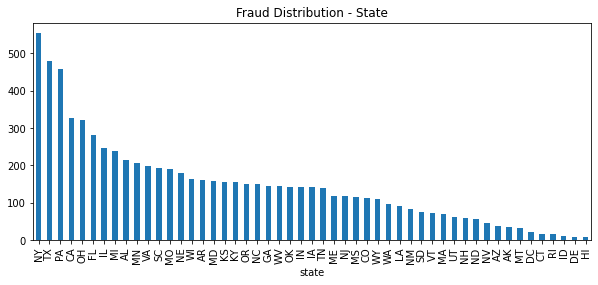

In [24]:
#Class Imbalance - Test
count_classes = df_train.groupby('state')['is_fraud'].sum().sort_values(ascending=False)
count_classes.plot(kind='bar', figsize=(10,4))
plt.title("Fraud Distribution - State")
plt.show()

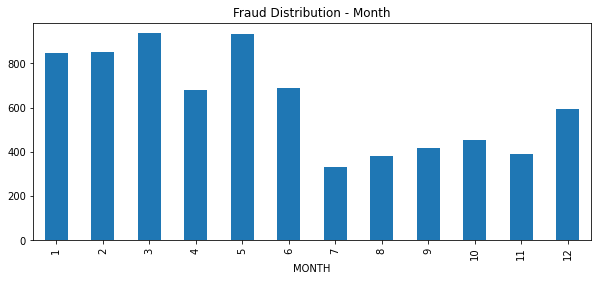

In [25]:
#Class Imbalance - Test
count_classes = df_train.groupby('MONTH')['is_fraud'].sum()
count_classes.plot(kind='bar', figsize=(10,4))
plt.title("Fraud Distribution - Month")
plt.show()

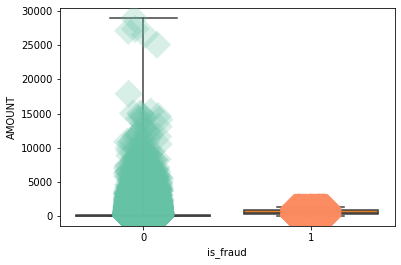

In [26]:
# Distribution of Transaction time for transactions
ax = sns.boxplot(x=df_train['is_fraud'], y=df_train['AMOUNT'], data=df_train, whis=np.inf)
ax = sns.stripplot(x=df_train['is_fraud'], y=df_train['AMOUNT'], data=df_train, palette="Set2", size=20, marker="D",
                   edgecolor="gray", alpha=.25)

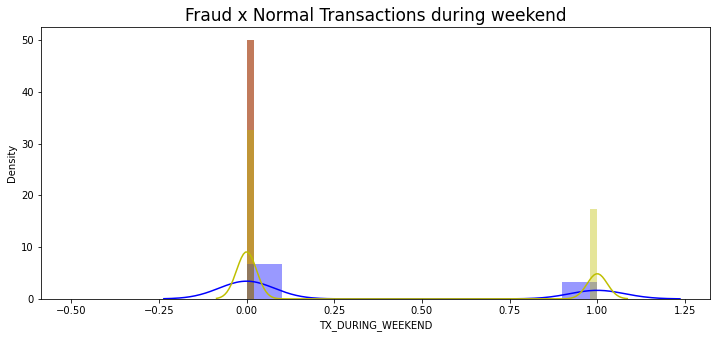

In [27]:
plt.figure(figsize=(12,5))
sns.distplot(df_train[df_train['is_fraud'] == 0]["TX_DURING_NIGHT"], color='g')
sns.distplot(df_train[df_train['is_fraud'] == 1]["TX_DURING_NIGHT"], color='r')
sns.distplot(df_train[df_train['is_fraud'] == 1]["TX_DURING_WEEKEND"], color='b')
sns.distplot(df_train[df_train['is_fraud'] == 0]["TX_DURING_WEEKEND"], color='y')
plt.title('Fraud x Normal Transactions during weekend', fontsize=17)

plt.show()

In [28]:
df_train.head(1)

,TX_DATETIME,ACCOUNT,merchant,CATEGORY,AMOUNT,first,last,gender,street,city,...,merch_long,is_fraud,Transaction_Date,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,YEAR,TX_TIME_DAYS
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,0,2019-01-01,34,0,0,1,1,2019,0


<AxesSubplot:title={'center':'Number of frauds by category'}, xlabel='CATEGORY', ylabel='is_fraud'>

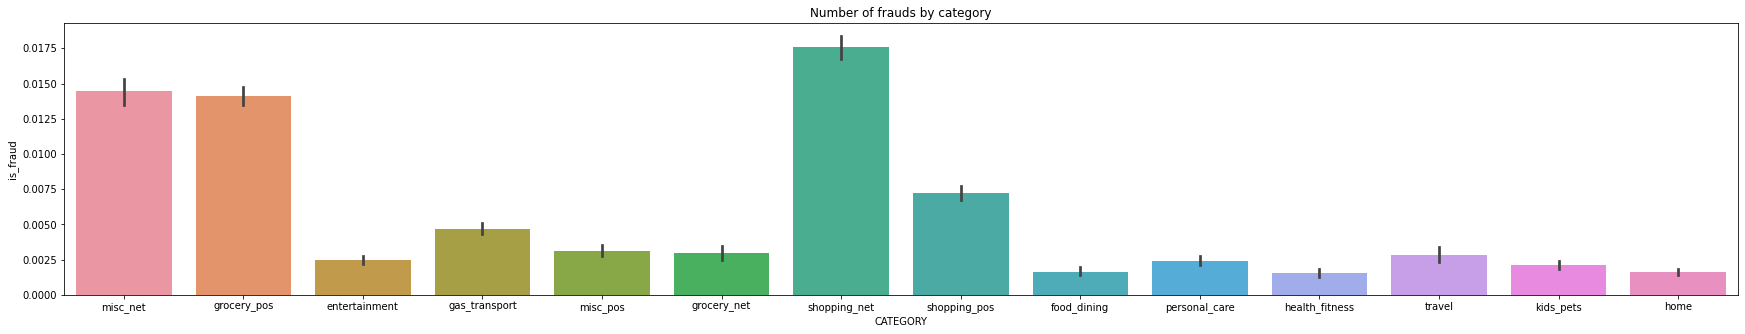

In [29]:
# # Distribution of Transaction time for Category
plt.figure(figsize=(30,5))
plt.title('Number of frauds by category')
sns.barplot(x=df_train['CATEGORY'], y=df_train['is_fraud'] ,data=df_train)


In [30]:
#drop column that we don't need
df_train.drop(['dob','Transaction_Date','TX_DATETIME', 'ACCOUNT', 'first', 'last', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'] , axis=1, inplace=True)
df_test.drop(['dob','Transaction_Date','TX_DATETIME', 'ACCOUNT', 'first', 'last', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'] , axis=1, inplace=True)

show_status(df_train)



,Null Values,% of Null Values,Type,Unique Values
merchant,0,0.0,object,693
CATEGORY,0,0.0,object,14
AMOUNT,0,0.0,float64,52928
gender,0,0.0,object,2
state,0,0.0,object,51
is_fraud,0,0.0,int64,2
Age,0,0.0,int64,81
TX_DURING_WEEKEND,0,0.0,int64,2
TX_DURING_NIGHT,0,0.0,int64,1
DAY,0,0.0,int64,31


In [31]:
print("Number of is_fraud data",df_train['is_fraud'].value_counts())

Number of is_fraud data 0    1289169
1       7506
Name: is_fraud, dtype: int64


In [32]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
ohe.fit(df_train[['CATEGORY']])

def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[['CATEGORY']]), columns=ohe.get_feature_names_out())
    df.drop(columns=['CATEGORY'], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df


df_train = get_ohe(df_train)
df_test = get_ohe(df_test)

In [33]:
df_downsampled = df_train
df_downsampled


,merchant,AMOUNT,gender,state,is_fraud,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,...,CATEGORY_grocery_pos,CATEGORY_health_fitness,CATEGORY_home,CATEGORY_kids_pets,CATEGORY_misc_net,CATEGORY_misc_pos,CATEGORY_personal_care,CATEGORY_shopping_net,CATEGORY_shopping_pos,CATEGORY_travel
0,"fraud_Rippin, Kub and Mann",4.97,F,NC,0,34,0,0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"fraud_Heller, Gutmann and Zieme",107.23,F,WA,0,44,0,0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fraud_Lind-Buckridge,220.11,M,ID,0,60,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"fraud_Kutch, Hermiston and Farrell",45.00,M,MT,0,55,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fraud_Keeling-Crist,41.96,M,VA,0,36,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,15.56,M,UT,0,61,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296671,fraud_Abernathy and Sons,51.70,M,MD,0,43,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296672,fraud_Stiedemann Ltd,105.93,M,NM,0,55,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296673,"fraud_Reinger, Weissnat and Strosin",74.90,M,SD,0,42,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Gender
#Change gender from nominal to numerical
# Train data
df_downsampled['gender'] = df_downsampled['gender'].replace(['F','M'],[0,1])
# Test data
df_test['gender'] = df_test['gender'].replace(['F','M'],[0,1])

In [35]:
#Select Data
select_data = df_downsampled
select_data.columns

Index(['merchant', 'AMOUNT', 'gender', 'state', 'is_fraud', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'TX_TIME_DAYS', 'CATEGORY_entertainment', 'CATEGORY_food_dining',
       'CATEGORY_gas_transport', 'CATEGORY_grocery_net',
       'CATEGORY_grocery_pos', 'CATEGORY_health_fitness', 'CATEGORY_home',
       'CATEGORY_kids_pets', 'CATEGORY_misc_net', 'CATEGORY_misc_pos',
       'CATEGORY_personal_care', 'CATEGORY_shopping_net',
       'CATEGORY_shopping_pos', 'CATEGORY_travel'],
      dtype='object')

In [36]:
select_data = select_data[['merchant', 'AMOUNT', 'gender', 'state', 'is_fraud', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'CATEGORY_food_dining', 'CATEGORY_gas_transport',
       'CATEGORY_grocery_net', 'CATEGORY_grocery_pos',
       'CATEGORY_health_fitness', 'CATEGORY_home', 'CATEGORY_kids_pets',
       'CATEGORY_misc_net', 'CATEGORY_misc_pos', 'CATEGORY_personal_care',
       'CATEGORY_shopping_net', 'CATEGORY_shopping_pos', 'CATEGORY_travel']]
select_data

,merchant,AMOUNT,gender,state,is_fraud,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,...,CATEGORY_grocery_pos,CATEGORY_health_fitness,CATEGORY_home,CATEGORY_kids_pets,CATEGORY_misc_net,CATEGORY_misc_pos,CATEGORY_personal_care,CATEGORY_shopping_net,CATEGORY_shopping_pos,CATEGORY_travel
0,"fraud_Rippin, Kub and Mann",4.97,0,NC,0,34,0,0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"fraud_Heller, Gutmann and Zieme",107.23,0,WA,0,44,0,0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fraud_Lind-Buckridge,220.11,1,ID,0,60,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"fraud_Kutch, Hermiston and Farrell",45.00,1,MT,0,55,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fraud_Keeling-Crist,41.96,1,VA,0,36,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,fraud_Reichel Inc,15.56,1,UT,0,61,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296671,fraud_Abernathy and Sons,51.70,1,MD,0,43,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296672,fraud_Stiedemann Ltd,105.93,1,NM,0,55,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296673,"fraud_Reinger, Weissnat and Strosin",74.90,1,SD,0,42,1,0,21,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
 select_data.columns

Index(['merchant', 'AMOUNT', 'gender', 'state', 'is_fraud', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'CATEGORY_food_dining', 'CATEGORY_gas_transport',
       'CATEGORY_grocery_net', 'CATEGORY_grocery_pos',
       'CATEGORY_health_fitness', 'CATEGORY_home', 'CATEGORY_kids_pets',
       'CATEGORY_misc_net', 'CATEGORY_misc_pos', 'CATEGORY_personal_care',
       'CATEGORY_shopping_net', 'CATEGORY_shopping_pos', 'CATEGORY_travel'],
      dtype='object')

In [38]:
from sklearn.model_selection import train_test_split
feature_cols = ['AMOUNT', 'gender', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'CATEGORY_food_dining', 'CATEGORY_gas_transport',
       'CATEGORY_grocery_net', 'CATEGORY_grocery_pos',
       'CATEGORY_health_fitness', 'CATEGORY_home', 'CATEGORY_kids_pets',
       'CATEGORY_misc_net', 'CATEGORY_misc_pos', 'CATEGORY_personal_care',
       'CATEGORY_shopping_net', 'CATEGORY_shopping_pos', 'CATEGORY_travel']
X = select_data[feature_cols]
y = select_data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=30)

In [39]:
X_train

,AMOUNT,gender,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,YEAR,CATEGORY_food_dining,CATEGORY_gas_transport,...,CATEGORY_grocery_pos,CATEGORY_health_fitness,CATEGORY_home,CATEGORY_kids_pets,CATEGORY_misc_net,CATEGORY_misc_pos,CATEGORY_personal_care,CATEGORY_shopping_net,CATEGORY_shopping_pos,CATEGORY_travel
1099647,65.76,0,35,0,0,2,4,2020,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905221,132.35,0,66,1,0,28,12,2019,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114636,5.49,0,54,0,0,8,4,2020,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666118,71.64,1,56,0,0,11,10,2019,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508851,36.38,0,56,0,0,9,8,2019,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222339,4.69,0,34,0,0,22,4,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
882485,4.37,1,23,1,0,22,12,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
328599,8.70,1,53,0,0,5,6,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
570508,28.84,0,66,0,0,30,8,2019,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
total = np.count_nonzero(y_test == 1)
total

2259

In [42]:
total = np.count_nonzero(y_test == 0)
total

386744

In [43]:
from imblearn.over_sampling import SMOTE
#balancing using SMOTE method
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [44]:
y_train.value_counts()

0    902425
1    902425
Name: is_fraud, dtype: int64

In [45]:
#Learning with Imbalanced Data
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# class_weight='balanced' to balance the classes which we have 0 and 1 in the outcome column
model = DecisionTreeClassifier(criterion="entropy", max_depth=10,random_state=42, class_weight='balanced')
model = model.fit(X_train, y_train)

In [46]:
# Accuracy of train data
y_pred_train = model.predict(X_train)
print("Accuracy Train Data:",metrics.accuracy_score(y_train, y_pred_train))

# Accuracy of test data
y_pred_test = model.predict(X_test)
print("Accuracy Test Data:",metrics.accuracy_score(y_test, y_pred_test))

Accuracy Train Data: 0.9649788071030834
Accuracy Test Data: 0.9623216273396349


In [47]:
from sklearn.metrics import confusion_matrix
# Train data
print("Confusion Matrix")
pd.DataFrame(confusion_matrix(y_train,y_pred_train), columns=['Predicted Nagative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

Confusion Matrix


,Predicted Nagative,Predicted Positive
Actual Negative,868798,33627
Actual Positive,29581,872844


In [48]:
print('Classifiaction report: \n', metrics.classification_report(y_train,y_pred_train))

Classifiaction report: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.96    902425
           1       0.96      0.97      0.97    902425

    accuracy                           0.96   1804850
   macro avg       0.96      0.96      0.96   1804850
weighted avg       0.96      0.96      0.96   1804850



In [49]:
#How to test a file once it is uploaded
import pandas as pd

df_sample = df_slice
df_sample.rename(columns={'trans_date_trans_time':'TX_DATETIME','cc_num':'ACCOUNT','amt':'AMOUNT', 'category':'CATEGORY'}, inplace=True)
df_sample

,TX_DATETIME,ACCOUNT,merchant,CATEGORY,AMOUNT,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2020-06-28 12:19:29,3514865930894695,fraud_Bednar PLC,kids_pets,14.18,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,Naval architect,1967-08-30,d4d106d5c9ffc1701c5f09afc2508685,1372421969,32.562022,-106.265694,0
19996,2020-06-28 12:19:41,3514897282719543,fraud_Lubowitz-Walter,kids_pets,98.79,Steven,Faulkner,M,841 Cheryl Centers Suite 115,Farmington,...,42.9580,-77.3083,10717,Cytogeneticist,1952-10-13,229e743464bd721b5654c4b196387291,1372421981,42.193183,-78.054448,0
19997,2020-06-28 12:21:01,4584931703207308232,fraud_Stamm-Rodriguez,misc_pos,46.10,Amanda,Gomez,F,8152 Brittany Centers,Dallas,...,32.8463,-96.6972,1263321,"Designer, ceramics/pottery",1975-04-16,877fbd4ffa4750c24a6a18244b079bba,1372422061,32.729529,-97.358421,0
19998,2020-06-28 12:21:17,36078114201167,"fraud_Schumm, McLaughlin and Carter",food_dining,22.89,Christopher,Horn,M,956 Sanchez Highway,Mallie,...,37.2692,-82.9161,798,Facilities manager,1926-06-26,182ce724e8c30907706e40b7690a3999,1372422077,37.758363,-82.949838,0


In [50]:
df_sample['TX_DATETIME'] = pd.to_datetime(df_sample['TX_DATETIME'], errors='coerce')
df_sample['dob'] = pd.to_datetime(df_sample['dob'], errors='coerce')
df_sample['Transaction_Date'] = (df_sample['TX_DATETIME']).dt.date.astype('datetime64[ns]')
#Manually calculate the age - seems to be faster
df_sample['Age'] = pd.Timestamp('now').year - df_sample['dob'].dt.year

In [51]:
#It takes 4 sec because it does comparation with the functions
%time df_sample['TX_DURING_WEEKEND']=df_sample.TX_DATETIME.apply(is_weekend)
%time df_sample['TX_DURING_NIGHT']=df_sample.TX_DATETIME.apply(is_night)
#it takes 90ms because it only converts the values using dt properties
%time df_sample['DAY'] = df_sample['TX_DATETIME'].dt.day
%time df_sample['MONTH'] = df_sample['TX_DATETIME'].dt.month
%time df_sample['YEAR'] = df_sample['TX_DATETIME'].dt.year


Wall time: 75 ms
Wall time: 117 ms
Wall time: 2 ms
Wall time: 2 ms
Wall time: 996 µs


In [52]:
df_sample = get_ohe(df_sample)

In [53]:
df_sample['is_fraud']

0        0
1        0
2        0
3        0
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: is_fraud, Length: 20000, dtype: int64

In [54]:
#Change gender from nominal to numerical

# Train data
df_sample['gender'] = df_sample['gender'].replace(['F','M'],[0,1])
# Test data
df_sample['gender'] = df_sample['gender'].replace(['F','M'],[0,1])

In [55]:
df_sample.drop(['dob','Transaction_Date','TX_DATETIME', 'ACCOUNT', 'first', 'last', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'] , axis=1, inplace=True)

select_data2 =df_sample
select_data2.columns

Index(['merchant', 'AMOUNT', 'gender', 'state', 'is_fraud', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'CATEGORY_entertainment', 'CATEGORY_food_dining',
       'CATEGORY_gas_transport', 'CATEGORY_grocery_net',
       'CATEGORY_grocery_pos', 'CATEGORY_health_fitness', 'CATEGORY_home',
       'CATEGORY_kids_pets', 'CATEGORY_misc_net', 'CATEGORY_misc_pos',
       'CATEGORY_personal_care', 'CATEGORY_shopping_net',
       'CATEGORY_shopping_pos', 'CATEGORY_travel'],
      dtype='object')

In [56]:
X = select_data2[feature_cols]
Y = select_data2['is_fraud']

In [57]:
from sklearn import preprocessing
feature_cols = ['AMOUNT', 'gender', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'CATEGORY_food_dining', 'CATEGORY_gas_transport',
       'CATEGORY_grocery_net', 'CATEGORY_grocery_pos',
       'CATEGORY_health_fitness', 'CATEGORY_home', 'CATEGORY_kids_pets',
       'CATEGORY_misc_net', 'CATEGORY_misc_pos', 'CATEGORY_personal_care',
       'CATEGORY_shopping_net', 'CATEGORY_shopping_pos', 'CATEGORY_travel']

X = X.reindex(columns=feature_cols).fillna(0)

X = scaler.transform(X)

In [58]:
X

array([[6.85871815e-05, 1.00000000e+00, 4.56790123e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.06347006e-03, 0.00000000e+00, 1.85185185e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.48531810e-03, 0.00000000e+00, 4.32098765e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.66305478e-03, 0.00000000e+00, 3.70370370e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.07190002e-04, 1.00000000e+00, 9.75308642e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.33947520e-04, 0.00000000e+00, 4.07407407e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [59]:
y_ = model.predict(X)
y_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
print("Accuracy Test Data:",metrics.accuracy_score(Y, y_))

Accuracy Test Data: 0.96345


In [61]:
len(y_)

20000

In [62]:
total = np.count_nonzero(y_ == 1)
total

789

In [63]:
total = np.count_nonzero(y_ == 0)
total

19211

In [64]:
print("Number of is_fraud data",df_sample['is_fraud'].value_counts())

Number of is_fraud data 0    19932
1       68
Name: is_fraud, dtype: int64


In [65]:
print('Classifiaction report: \n', metrics.classification_report(Y, y_))

Classifiaction report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     19932
           1       0.08      0.93      0.15        68

    accuracy                           0.96     20000
   macro avg       0.54      0.95      0.56     20000
weighted avg       1.00      0.96      0.98     20000



In [66]:
print("Confusion Matrix")

pd.DataFrame(confusion_matrix(Y, y_), columns=['Predicted Nagative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

Confusion Matrix


,Predicted Nagative,Predicted Positive
Actual Negative,19206,726
Actual Positive,5,63


In [107]:
#accuracy = (TP+TN)/Total

tp = 63
tn = 19206
fp = 726
fn = 5

total = tp+tn+fp+fn

actualPositive=tp+fp
actualNegative=fn+tn
predPositive = tp + fn
predNegative = fp + tn

acc = (tp+tn)/total
print(acc)

0.96345


In [108]:
#how often is wrong
rate = (fp+fn)/total
print(rate)

0.03655


In [109]:
#true positive rate
print((tp/actualPositive))

0.07984790874524715


In [110]:
#false positive rate
print((fp/actualNegative))

0.03779084899276456


In [111]:
#True negative rate
print((tn/actualNegative))

0.9997397324449534


In [112]:
#recall
print(tp/(fn+tp))

0.9264705882352942


In [73]:
#####################Different models


In [74]:
df_train = df_train1
df_test = df_test1

In [75]:
#df_train = df_train.drop('Unnamed: 0', axis=1)
#train dataset
df_train.rename(columns={'trans_date_trans_time':'TX_DATETIME','cc_num':'ACCOUNT','amt':'AMOUNT', 'category':'CATEGORY'}, inplace=True)
#test dataset
df_test.rename(columns={'trans_date_trans_time':'TX_DATETIME','cc_num':'ACCOUNT','amt':'AMOUNT', 'category':'CATEGORY'}, inplace=True)

In [76]:
#Data Tranformation

df_train['TX_DATETIME'] = pd.to_datetime(df_train['TX_DATETIME'], errors='coerce')
df_train['dob'] = pd.to_datetime(df_train['dob'], errors='coerce')
df_train['Transaction_Date'] = (df_train['TX_DATETIME']).dt.date.astype('datetime64[ns]')
#Manually calculate the age - seems to be faster
df_train['Age'] = pd.Timestamp('now').year - df_train['dob'].dt.year

df_test['TX_DATETIME'] = pd.to_datetime(df_test['TX_DATETIME'], errors='coerce')
df_test['dob'] = pd.to_datetime(df_test['dob'], errors='coerce')
df_test['Transaction_Date'] = (df_test['TX_DATETIME']).dt.date.astype('datetime64[ns]')
#Manually calculate the age - seems to be faster
df_test['Age'] = pd.Timestamp('now').year - df_test['dob'].dt.year

In [77]:
#Data Tranformation

#It takes 4 sec because it does comparation with the functions
%time df_train['TX_DURING_WEEKEND']=df_train.TX_DATETIME.apply(is_weekend)
%time df_train['TX_DURING_NIGHT']=df_train.TX_DATETIME.apply(is_night)
#it takes 90ms because it only converts the values using dt properties
%time df_train['DAY'] = df_train['TX_DATETIME'].dt.day
%time df_train['MONTH'] = df_train['TX_DATETIME'].dt.month
%time df_train['YEAR'] = df_train['TX_DATETIME'].dt.year


df_test['TX_DURING_WEEKEND']=df_test.TX_DATETIME.apply(is_weekend)
df_test['TX_DURING_NIGHT']=df_test.TX_DATETIME.apply(is_night)
df_test['DAY'] = df_test['TX_DATETIME'].dt.day
df_test['MONTH'] = df_test['TX_DATETIME'].dt.month
df_test['YEAR'] = df_test['TX_DATETIME'].dt.year

Wall time: 5.01 s
Wall time: 4.92 s
Wall time: 97 ms
Wall time: 104 ms
Wall time: 96 ms


In [78]:
#Data Tranformation

#If I want to check the elapse of days since the first day from the dataset
df_train_min = min(df_train['TX_DATETIME'])
df_test_min = min(df_test['TX_DATETIME'])

df_train['TX_TIME_DAYS'] = [int(i.days) for i in (df_train['TX_DATETIME']) - df_train_min]
df_test['TX_TIME_DAYS'] = [int(i.days) for i in (df_test['TX_DATETIME']) - df_test_min]

df_train.head(2)

,TX_DATETIME,ACCOUNT,merchant,CATEGORY,AMOUNT,first,last,gender,street,city,...,merch_long,is_fraud,Transaction_Date,Age,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,YEAR,TX_TIME_DAYS
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,0,2019-01-01,34,0,0,1,1,2019,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,0,2019-01-01,44,0,0,1,1,2019,0


In [79]:
#drop column that we don't need
df_train.drop(['dob','Transaction_Date','TX_DATETIME', 'ACCOUNT', 'first', 'last', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'] , axis=1, inplace=True)
df_test.drop(['dob','Transaction_Date','TX_DATETIME', 'ACCOUNT', 'first', 'last', 'street', 'city', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'] , axis=1, inplace=True)

show_status(df_train)

,Null Values,% of Null Values,Type,Unique Values
merchant,0,0.0,object,693
CATEGORY,0,0.0,object,14
AMOUNT,0,0.0,float64,52928
gender,0,0.0,object,2
state,0,0.0,object,51
is_fraud,0,0.0,int64,2
Age,0,0.0,int64,81
TX_DURING_WEEKEND,0,0.0,int64,2
TX_DURING_NIGHT,0,0.0,int64,1
DAY,0,0.0,int64,31


In [80]:
from sklearn.utils import resample 
df_minority = df_train[df_train.iloc[:,5].values==0] # .iloc[:,21] = is_fraud
df_majority = df_train[df_train.iloc[:,5].values==1] 

# Downsample majority class
df_minority_downsampled = resample(df_minority,
                                 n_samples=7506,     # to match minority class
                                 random_state=42)    # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_minority_downsampled, df_majority])
 
# Display new class counts
df_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 123118 to 1295733
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   merchant           15012 non-null  object 
 1   CATEGORY           15012 non-null  object 
 2   AMOUNT             15012 non-null  float64
 3   gender             15012 non-null  object 
 4   state              15012 non-null  object 
 5   is_fraud           15012 non-null  int64  
 6   Age                15012 non-null  int64  
 7   TX_DURING_WEEKEND  15012 non-null  int64  
 8   TX_DURING_NIGHT    15012 non-null  int64  
 9   DAY                15012 non-null  int64  
 10  MONTH              15012 non-null  int64  
 11  YEAR               15012 non-null  int64  
 12  TX_TIME_DAYS       15012 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 1.6+ MB


In [81]:
#The new dataframe show the same amout of fraud and non fraud values
print("Number of is_fraud data",df_downsampled['is_fraud'].value_counts())

Number of is_fraud data 0    7506
1    7506
Name: is_fraud, dtype: int64


In [82]:
#Data Tranformation

#Category (One-Hot Endcoding)
#Change Category's Nominal Data to numerical by One Hot Encoding

#train data
#one-hot encoding the category variable
category_onehot = pd.get_dummies(df_downsampled.CATEGORY, prefix='CATEGORY', drop_first=True)
#one-hot encoding the gender variable

MONTH_onehot = pd.get_dummies(df_downsampled.MONTH, prefix='MONTH', drop_first=True)
#Age_onehot = pd.get_dummies(df_downsampled.Age, prefix='Age', drop_first=True)


df_downsampled = df_downsampled.join(category_onehot)
df_downsampled = df_downsampled.join(MONTH_onehot)
#df_downsampled = df_downsampled.join(Age_onehot)

In [83]:
#test data
#one-hot encoding the category variable
category_onehot = pd.get_dummies(df_test.CATEGORY, prefix='CATEGORY', drop_first=True)
#one-hot encoding the gender variable
MONTH_onehot = pd.get_dummies(df_test.MONTH, prefix='MONTH', drop_first=True)
#Age_onehot = pd.get_dummies(df_test.Age, prefix='Age', drop_first=True)


df_test = df_test.join(category_onehot)

df_test = df_test.join(MONTH_onehot)
#df_test = df_test.join(Age_onehot)

In [84]:
#Gender
#Change gender from nominal to numerical

# Train data
df_downsampled['gender'] = df_downsampled['gender'].replace(['F','M'],[0,1])
# Test data
df_test['gender'] = df_test['gender'].replace(['F','M'],[0,1])

print('Gender of train dataset', df_downsampled['gender'].value_counts())
print('Gender of test dataset', df_test['gender'].value_counts())


Gender of train dataset 0    8039
1    7135
Name: gender, dtype: int64
Gender of test dataset 0    282994
1    232725
Name: gender, dtype: int64


In [85]:
#Select Data
select_data = df_downsampled
select_data.columns

Index(['merchant', 'CATEGORY', 'AMOUNT', 'gender', 'state', 'is_fraud', 'Age',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'TX_TIME_DAYS', 'CATEGORY_food_dining', 'CATEGORY_gas_transport',
       'CATEGORY_grocery_net', 'CATEGORY_grocery_pos',
       'CATEGORY_health_fitness', 'CATEGORY_home', 'CATEGORY_kids_pets',
       'CATEGORY_misc_net', 'CATEGORY_misc_pos', 'CATEGORY_personal_care',
       'CATEGORY_shopping_net', 'CATEGORY_shopping_pos', 'CATEGORY_travel',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object')

In [86]:
select_data = select_data[['AMOUNT', 'Age','gender',
       'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'DAY', 'MONTH', 'YEAR',
       'CATEGORY_food_dining', 'CATEGORY_gas_transport',
       'CATEGORY_grocery_net', 'CATEGORY_grocery_pos',
       'CATEGORY_health_fitness', 'CATEGORY_home', 'CATEGORY_kids_pets',
       'CATEGORY_misc_net', 'CATEGORY_misc_pos', 'CATEGORY_personal_care',
       'CATEGORY_shopping_net', 'CATEGORY_shopping_pos', 'CATEGORY_travel',
       'is_fraud']]
select_data.head()

,AMOUNT,Age,gender,TX_DURING_WEEKEND,TX_DURING_NIGHT,DAY,MONTH,YEAR,CATEGORY_food_dining,CATEGORY_gas_transport,...,CATEGORY_health_fitness,CATEGORY_home,CATEGORY_kids_pets,CATEGORY_misc_net,CATEGORY_misc_pos,CATEGORY_personal_care,CATEGORY_shopping_net,CATEGORY_shopping_pos,CATEGORY_travel,is_fraud
126,58.79,64,0,0,0,1,1,2019,0,1,...,0,0,0,0,0,0,0,0,0,0
159,14.03,41,0,0,0,1,1,2019,0,0,...,0,0,0,1,0,0,0,0,0,0
215,128.24,58,1,0,0,1,1,2019,0,0,...,0,0,0,0,0,0,0,0,0,0
404,124.33,32,0,0,0,1,1,2019,0,0,...,0,0,0,0,0,0,0,0,0,0
727,65.74,74,1,0,0,1,1,2019,0,0,...,0,0,0,0,0,0,0,0,0,0


[8.03572279e-02 3.43049213e-03 2.72993515e-03 4.89533793e-04
 0.00000000e+00 1.80364094e-03 2.62837719e-03 5.01970074e-04
 2.44623550e-03 1.08963806e-03 4.16083991e-04 1.35283540e-02
 2.60637805e-03 6.54542637e-03 3.21310240e-03 7.64767947e-03
 5.57259491e-04 9.32980984e-04 2.18902643e-02 1.24863403e-03
 3.79073026e-04 8.45557713e-01]


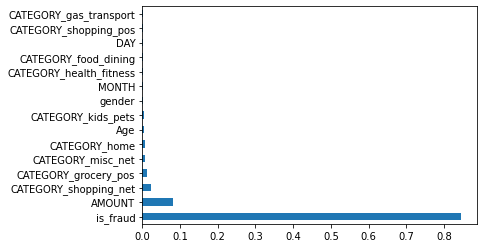

In [87]:
#ExtraTreesClassifier
X = select_data.iloc[:,0:22]  #independent columns
y = select_data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [88]:
#using train extra tree
select_data_train_extra_tree = df_downsampled[['is_fraud', 'CATEGORY_personal_care',
'DAY',
'CATEGORY_shopping_pos',
'CATEGORY_food_dining',
'MONTH',
'gender',
'CATEGORY_kids_pets',
'CATEGORY_health_fitness',
'Age',
'CATEGORY_home',
'CATEGORY_misc_net',
'CATEGORY_grocery_pos',
'CATEGORY_shopping_net',
'AMOUNT']]

In [89]:
#nlargest
print(select_data.corr().abs().nlargest(15, 'is_fraud').index)

Index(['is_fraud', 'AMOUNT', 'CATEGORY_shopping_net', 'CATEGORY_grocery_pos',
       'CATEGORY_home', 'CATEGORY_misc_net', 'CATEGORY_kids_pets',
       'CATEGORY_health_fitness', 'CATEGORY_food_dining',
       'CATEGORY_personal_care', 'MONTH', 'Age', 'gender', 'CATEGORY_misc_pos',
       'CATEGORY_grocery_net'],
      dtype='object')


In [90]:
#using nlargest
select_data_train_abs_nlargest = df_downsampled[['is_fraud', 'AMOUNT', 'CATEGORY_shopping_net', 'CATEGORY_grocery_pos',
       'CATEGORY_home', 'CATEGORY_misc_net', 'CATEGORY_kids_pets',
       'CATEGORY_health_fitness', 'CATEGORY_food_dining',
       'CATEGORY_personal_care', 'MONTH', 'Age', 'gender', 'CATEGORY_misc_pos',
       'CATEGORY_grocery_net']]

In [91]:
#Select Test Data - extra tree
select_data_test_extra_tree = df_test[['is_fraud', 'CATEGORY_personal_care',
'DAY',
'CATEGORY_shopping_pos',
'CATEGORY_food_dining',
'MONTH',
'gender',
'CATEGORY_kids_pets',
'CATEGORY_health_fitness',
'Age',
'CATEGORY_home',
'CATEGORY_misc_net',
'CATEGORY_grocery_pos',
'CATEGORY_shopping_net',
'AMOUNT']]

select_data_test_abs_nlargest = df_test[['is_fraud', 'AMOUNT', 'CATEGORY_shopping_net', 'CATEGORY_grocery_pos',
       'CATEGORY_home', 'CATEGORY_misc_net', 'CATEGORY_kids_pets',
       'CATEGORY_health_fitness', 'CATEGORY_food_dining',
       'CATEGORY_personal_care', 'MONTH', 'Age', 'gender', 'CATEGORY_misc_pos',
       'CATEGORY_grocery_net']]

In [92]:
# Prepare X_train y_train
X_train_extra_tree = select_data_train_extra_tree[['CATEGORY_personal_care',
'DAY',
'CATEGORY_shopping_pos',
'CATEGORY_food_dining',
'MONTH',
'gender',
'CATEGORY_kids_pets',
'CATEGORY_health_fitness',
'Age',
'CATEGORY_home',
'CATEGORY_misc_net',
'CATEGORY_grocery_pos',
'CATEGORY_shopping_net',
'AMOUNT']]
y_train_extra_tree = select_data_train_extra_tree['is_fraud']

X_train_abs_nlargest = select_data_train_abs_nlargest[['AMOUNT', 'CATEGORY_shopping_net', 'CATEGORY_grocery_pos',
       'CATEGORY_home', 'CATEGORY_misc_net', 'CATEGORY_kids_pets',
       'CATEGORY_health_fitness', 'CATEGORY_food_dining',
       'CATEGORY_personal_care', 'MONTH', 'Age', 'gender', 'CATEGORY_misc_pos',
       'CATEGORY_grocery_net']]
y_train_abs_nlargest = select_data_train_abs_nlargest['is_fraud']

In [93]:
# Prepare X_test y_test
X_test_extra_tree = select_data_test_extra_tree[['CATEGORY_personal_care',
'DAY',
'CATEGORY_shopping_pos',
'CATEGORY_food_dining',
'MONTH',
'gender',
'CATEGORY_kids_pets',
'CATEGORY_health_fitness',
'Age',
'CATEGORY_home',
'CATEGORY_misc_net',
'CATEGORY_grocery_pos',
'CATEGORY_shopping_net',
'AMOUNT']]
y_test_extra_tree = select_data_test_extra_tree['is_fraud']

X_test_abs_nlargest = select_data_test_abs_nlargest[['AMOUNT', 'CATEGORY_shopping_net', 'CATEGORY_grocery_pos',
       'CATEGORY_home', 'CATEGORY_misc_net', 'CATEGORY_kids_pets',
       'CATEGORY_health_fitness', 'CATEGORY_food_dining',
       'CATEGORY_personal_care', 'MONTH', 'Age', 'gender', 'CATEGORY_misc_pos',
       'CATEGORY_grocery_net']]
y_test_abs_nlargest = select_data_test_abs_nlargest['is_fraud']

In [94]:
#Scaler Data
from sklearn import preprocessing

# Scale X_train
# Extra Tree
scaler = preprocessing.MinMaxScaler()
newValue = scaler.fit_transform(X_train_extra_tree)
X_train_extra_tree_scaler = pd.DataFrame(newValue, columns=X_train_extra_tree.columns)
X_train_extra_tree_scaler

,CATEGORY_personal_care,DAY,CATEGORY_shopping_pos,CATEGORY_food_dining,MONTH,gender,CATEGORY_kids_pets,CATEGORY_health_fitness,Age,CATEGORY_home,CATEGORY_misc_net,CATEGORY_grocery_pos,CATEGORY_shopping_net,AMOUNT
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.580247,0.0,0.0,0.0,0.0,0.003994
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.296296,0.0,1.0,0.0,0.0,0.000900
2,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.506173,0.0,0.0,1.0,0.0,0.008795
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.185185,0.0,0.0,1.0,0.0,0.008524
4,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.703704,0.0,0.0,0.0,0.0,0.004474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15169,0.0,0.666667,0.0,0.0,0.454545,1.0,0.0,0.0,0.370370,0.0,0.0,1.0,0.0,0.004588
15170,0.0,0.666667,0.0,0.0,0.454545,1.0,0.0,0.0,0.135802,0.0,0.0,0.0,0.0,0.000635
15171,0.0,0.666667,0.0,0.0,0.454545,0.0,0.0,0.0,0.395062,0.0,0.0,1.0,0.0,0.006693
15172,0.0,0.666667,0.0,0.0,0.454545,0.0,0.0,0.0,0.358025,0.0,1.0,0.0,0.0,0.005938


In [95]:
# Abs nlargest
scaler = preprocessing.MinMaxScaler()
newValue = scaler.fit_transform(X_train_abs_nlargest)
X_train_abs_nlargest_scaler = pd.DataFrame(newValue, columns=X_train_abs_nlargest.columns)
X_train_abs_nlargest_scaler

,AMOUNT,CATEGORY_shopping_net,CATEGORY_grocery_pos,CATEGORY_home,CATEGORY_misc_net,CATEGORY_kids_pets,CATEGORY_health_fitness,CATEGORY_food_dining,CATEGORY_personal_care,MONTH,Age,gender,CATEGORY_misc_pos,CATEGORY_grocery_net
0,0.003994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.580247,0.0,0.0,0.0
1,0.000900,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.296296,0.0,0.0,0.0
2,0.008795,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.506173,1.0,0.0,0.0
3,0.008524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.185185,0.0,0.0,0.0
4,0.004474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.703704,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15169,0.004588,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.370370,1.0,0.0,0.0
15170,0.000635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.135802,1.0,0.0,0.0
15171,0.006693,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.395062,0.0,0.0,0.0
15172,0.005938,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.454545,0.358025,0.0,0.0,0.0


In [96]:
# Scale X_test
# Extra Tree
scaler = preprocessing.MinMaxScaler()
newValue = scaler.fit_transform(X_test_extra_tree)
X_test_extra_tree_scaler = pd.DataFrame(newValue, columns=X_test_extra_tree.columns)
X_test_extra_tree_scaler

,CATEGORY_personal_care,DAY,CATEGORY_shopping_pos,CATEGORY_food_dining,MONTH,gender,CATEGORY_kids_pets,CATEGORY_health_fitness,Age,CATEGORY_home,CATEGORY_misc_net,CATEGORY_grocery_pos,CATEGORY_shopping_net,AMOUNT
0,0.0,0.133333,1.0,0.0,0.0,0.0,0.0,0.0,0.123457,0.0,0.0,0.0,0.0,0.000265
1,0.0,0.133333,0.0,0.0,0.0,1.0,0.0,0.0,0.098765,1.0,0.0,0.0,0.0,0.004544
2,0.0,0.133333,0.0,0.0,0.0,0.0,1.0,0.0,0.382716,0.0,0.0,0.0,0.0,0.003776
3,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,1.0,0.0,0.0,0.0,0.000746
4,0.0,0.133333,0.0,0.0,0.0,1.0,0.0,0.0,0.098765,0.0,0.0,0.0,1.0,0.000341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515714,0.0,1.000000,0.0,0.0,1.0,1.0,0.0,1.0,0.481481,0.0,0.0,0.0,0.0,0.001879
515715,0.0,1.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.004868
515716,0.0,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.296296,0.0,0.0,0.0,0.0,0.003772
515717,0.0,1.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.493827,0.0,0.0,0.0,0.0,0.000307


In [97]:
# nlargest
scaler = preprocessing.MinMaxScaler()
newValue = scaler.fit_transform(X_test_abs_nlargest)
X_test_abs_nlargest_scaler = pd.DataFrame(newValue, columns=X_test_abs_nlargest.columns)
X_test_abs_nlargest_scaler

,AMOUNT,CATEGORY_shopping_net,CATEGORY_grocery_pos,CATEGORY_home,CATEGORY_misc_net,CATEGORY_kids_pets,CATEGORY_health_fitness,CATEGORY_food_dining,CATEGORY_personal_care,MONTH,Age,gender,CATEGORY_misc_pos,CATEGORY_grocery_net
0,0.000265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123457,0.0,0.0,0.0
1,0.004544,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098765,1.0,0.0,0.0
2,0.003776,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.382716,0.0,0.0,0.0
3,0.000746,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0
4,0.000341,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098765,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515714,0.001879,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.481481,1.0,0.0,0.0
515715,0.004868,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.074074,1.0,0.0,0.0
515716,0.003772,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.296296,0.0,0.0,0.0
515717,0.000307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.493827,1.0,0.0,0.0


In [98]:
#Model
#LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
# Extra Tree
model_ext = LogisticRegression(random_state=42)
model_ext.fit(X_train_extra_tree_scaler, y_train_extra_tree)

# nlargest
model_nr = LogisticRegression(random_state=0)
model_nr.fit(X_train_abs_nlargest_scaler, y_train_abs_nlargest)

LogisticRegression(random_state=0)

In [100]:
# Extra Tree - Predict
y_pred_extra_tree_scaler = model_ext.predict(X_test_extra_tree_scaler)

# nlargest - Predict
y_pred_abs_nlargest_scaler = model_nr.predict(X_test_abs_nlargest_scaler)

In [101]:
# Extra Tree - Confusion matrix
print("Select Data By Extra Tree")
print(pd.DataFrame(confusion_matrix(y_test_extra_tree,y_pred_extra_tree_scaler), columns=['Predicted Positive', 'Predicted Nagative'], index=['Actual Positive', 'Actual Negative']))

# nlargest - Confusion matrix
print("Select Data By Abs nlargest")
print(pd.DataFrame(confusion_matrix(y_test_abs_nlargest,y_pred_abs_nlargest_scaler), columns=['Predicted Positive', 'Predicted Nagative'], index=['Actual Positive', 'Actual Negative']))

Select Data By Extra Tree
                 Predicted Positive  Predicted Nagative
Actual Positive              466032               47710
Actual Negative                 604                1373
Select Data By Abs nlargest
                 Predicted Positive  Predicted Nagative
Actual Positive              465376               48366
Actual Negative                 586                1391


In [102]:
# Extra Tree - Classification Report
print("Classification report (Select Data By Extra Tree)")
print(classification_report(y_test_extra_tree, y_pred_extra_tree_scaler))

# nlargest - Classification Report
print("Classification report (Select Data By Abs nlargest)")
print(classification_report(y_test_abs_nlargest, y_pred_abs_nlargest_scaler))

Classification report (Select Data By Extra Tree)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    513742
           1       0.03      0.69      0.05      1977

    accuracy                           0.91    515719
   macro avg       0.51      0.80      0.50    515719
weighted avg       0.99      0.91      0.95    515719

Classification report (Select Data By Abs nlargest)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    513742
           1       0.03      0.70      0.05      1977

    accuracy                           0.91    515719
   macro avg       0.51      0.80      0.50    515719
weighted avg       1.00      0.91      0.95    515719



In [103]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth=10,random_state=42, class_weight='balanced')

# Extra Tree - Fit Model
dt_clf.fit(X_train_extra_tree_scaler, y_train_extra_tree)

# nlargest - Fit Model
dt_clf.fit(X_train_abs_nlargest_scaler, y_train_abs_nlargest)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [104]:
#Extra Tree - Confusion matrix
print("Confusion Matrix(Select Data By Extra Tree)")
pred_test_extrea_tree_scaler = dt_clf.predict(X_test_extra_tree_scaler)
pd.DataFrame(confusion_matrix(y_test_extra_tree,pred_test_extrea_tree_scaler), columns=['Predicted Positive', 'Predicted Nagative'], index=['Actual Positive', 'Actual Negative'])

Confusion Matrix(Select Data By Extra Tree)


,Predicted Positive,Predicted Nagative
Actual Positive,499514,14228
Actual Negative,1875,102


In [105]:
# nlargest - Confusion matrix
print("Confusion Matrix(Select Data By Abs nlargest)")
pred_test_abs_nlargest_scaler = dt_clf.predict(X_test_abs_nlargest_scaler)
pd.DataFrame(confusion_matrix(y_test_abs_nlargest,pred_test_abs_nlargest_scaler), columns=['Predicted Positive', 'Predicted Nagative'], index=['Actual Positive', 'Actual Negative'])

Confusion Matrix(Select Data By Abs nlargest)


,Predicted Positive,Predicted Nagative
Actual Positive,465796,47946
Actual Negative,1325,652


In [106]:
# Extra Tree - Classification report
print("Classification report (Select Data By Extra Tree)")
print(classification_report(y_test_extra_tree, pred_test_extrea_tree_scaler))


# nlargest - Classification report
print("Classification report (Select Data By nlargest)")
print(classification_report(y_test_abs_nlargest, pred_test_abs_nlargest_scaler))

Classification report (Select Data By Extra Tree)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    513742
           1       0.01      0.05      0.01      1977

    accuracy                           0.97    515719
   macro avg       0.50      0.51      0.50    515719
weighted avg       0.99      0.97      0.98    515719

Classification report (Select Data By nlargest)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    513742
           1       0.01      0.33      0.03      1977

    accuracy                           0.90    515719
   macro avg       0.51      0.62      0.49    515719
weighted avg       0.99      0.90      0.95    515719

